### Naive Bayes classifiers for safe driver prediction

In this exercise, let us build a predictive classification model using naive Bayes classifier. We will consider a binary target and a mix of discrete and continuous data. Let us examine a car insurance data from Kaggle platform and build naive Bayes classifying models. The dataset can be found at: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data


Let us first select the features that are most correlated with the target variable.

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

In [2]:
df_train = pd.read_csv('./train.csv',index_col='id')
df_train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
# Columns with continuous data
cont_cols = [i for i in df_train.columns if (df_train[i].dtype=='float' 
                                             or df_train[i].dtype=='float64')]
# Identifying columns with most missing values
df_train[cont_cols] = df_train[cont_cols].replace(-1,np.NaN)
num_missing_vals = df_train.replace(-1,np.NaN).isna().sum()/len(df_train)
selected_cols = num_missing_vals[num_missing_vals<0.4].index.tolist()
print('Columns with most missing values: ', 
      list(set(df_train.columns)-set(selected_cols)))
(num_missing_vals.sort_values(ascending=False)*100).head(10)

Columns with most missing values:  ['ps_car_03_cat', 'ps_car_05_cat']


ps_car_03_cat    69.089837
ps_car_05_cat    44.782531
ps_reg_03        18.106490
ps_car_14         7.160474
ps_car_07_cat     1.930237
ps_ind_05_cat     0.975955
ps_car_09_cat     0.095596
ps_ind_02_cat     0.036290
ps_car_01_cat     0.017977
ps_ind_04_cat     0.013945
dtype: float64

In [4]:
# Imputions of missing columns with integer data
int_cols = [i for i in num_missing_vals[num_missing_vals>0].index 
            if i not in cont_cols]
df_train[int_cols]= df_train[int_cols].apply(lambda x:x.replace(
    -1,x.value_counts().idxmax()))
# Imputions of missing columns with continous (float) data
mean_imp = SimpleImputer()
df_train[cont_cols] = mean_imp.fit_transform(df_train[cont_cols])
X_train = df_train.drop(['target'],axis=1)
y_train = df_train['target']
pd.DataFrame(sorted([(i,abs(np.corrcoef(y_train,X_train[i])[1,0])) 
                     for i in X_train.columns
                    if abs(np.corrcoef(y_train,X_train[i])[1,0])>0.03],
                    key=lambda x: x[1],reverse=True),
             columns=['Features','corr_with_target'])

,Features,corr_with_target
0,ps_car_13,0.053899
1,ps_car_12,0.038800
2,ps_ind_17_bin,0.037053
3,ps_reg_02,0.034800
4,ps_ind_07_bin,0.034218
5,ps_ind_06_bin,0.034017
6,ps_car_04_cat,0.032900
7,ps_car_03_cat,0.032401
8,ps_car_02_cat,0.031545
9,ps_reg_03,0.031258


### Naive Bayes classifiers

Loading the datsets only with selected columns, let us fit naive Bayes classifiers and compare their results

#### Bernoulli naive Bayes classifier

In [5]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

useful_cols=['ps_car_12', 'ps_car_04_cat', 'ps_ind_17_bin', 'ps_ind_05_cat', 
             'ps_ind_07_bin', 'ps_reg_03', 'ps_car_13', 'ps_ind_06_bin', 
             'ps_car_02_cat', 'ps_reg_02']

# Uncomment when not considering features with more than 0.5 correlation: 'ps_car_12' and 'ps_reg_03'
# useful_cols=['ps_car_04_cat', 'ps_ind_17_bin', 'ps_ind_05_cat', 
#              'ps_ind_07_bin', 'ps_car_13', 'ps_ind_06_bin', 
#              'ps_car_02_cat', 'ps_reg_02']

df_train = pd.read_csv('./train.csv', usecols=useful_cols+['target']+['id'],index_col='id')
df_test = pd.read_csv('./test.csv', usecols=useful_cols+['id'],index_col='id')
cont_cols = [i for i in df_train.columns 
                      if (df_train[i].dtype=='float' or df_train[i].dtype=='float64')]
int_cols = list(set(useful_cols)-set(cont_cols))
# Missing columns and imputation
df_train[cont_cols]=df_train[cont_cols].replace(-1,np.NaN)
df_test[cont_cols]=df_test[cont_cols].replace(-1,np.NaN)
df_train[int_cols]=df_train[int_cols].apply(lambda x:x.replace(-1,x.value_counts().idxmax()))
df_test[int_cols]=df_test[int_cols].apply(lambda x:x.replace(-1,x.value_counts().idxmax()))
mean_imp = SimpleImputer()
df_train[cont_cols] = mean_imp.fit_transform(df_train[cont_cols])
df_test[cont_cols] = mean_imp.fit_transform(df_test[cont_cols])
X_train = df_train.drop(['target'],axis=1)
y_train = df_train['target']
# Binary and categorical columns
bin_cols = [i for i in X_train.columns if 'bin' in i]
cat_cols = list(set(X_train.columns)-set(cont_cols)-set(bin_cols))

In [6]:
# Binning of continuous columns
X_train['ps_car_13']=pd.qcut(X_train['ps_car_13'],4,labels=False)
X_train['ps_reg_02']=pd.qcut(X_train['ps_reg_02'],4,labels=False)
# Comment below when 'ps_reg_03' and 'ps_car_12' are not considered
X_train['ps_reg_03']=pd.qcut(X_train['ps_reg_03'],4,labels=False)
X_train['ps_car_12']=pd.qcut(X_train['ps_car_12'],4,labels=False)
#---------------------------------
df_test['ps_car_13']=pd.qcut(df_test['ps_car_13'],4,labels=False)
df_test['ps_reg_02']=pd.qcut(df_test['ps_reg_02'],4,labels=False)
# Comment below when 'ps_reg_03' and 'ps_car_12' are not considered
df_test['ps_car_12']=pd.qcut(df_test['ps_car_12'],4,labels=False)
df_test['ps_reg_03']=pd.qcut(df_test['ps_reg_03'],4,labels=False)

# One-hot encoding and fitting Bernoulli naive Bayes model
oh = OneHotEncoder(handle_unknown='ignore')
oh_X = oh.fit_transform(X_train)
clf = BernoulliNB()
clf.fit(oh_X,y_train)
oh_test = oh.transform(df_test)
df_test['target']=list(map(lambda x:x[1], clf.predict_proba(oh_test)))
# Submission
df_sub=pd.DataFrame()
df_sub['id']=df_test.index.tolist()
df_sub['target']=df_test['target'].tolist()
df_sub=df_sub.set_index('id')
df_sub.to_csv('submission.csv')

The score of Bernoulli naive Bayes model is 0.2068 when all the features are considered.

Features that are correlated with each other with Pearson's coefficient > 0.5 are eliminated and when 'ps_reg_03' and 'ps_car_12' are not considered the score is 0.2074

#### Mixed naive Bayes classifier

With different types of features, let us fit appropriate naive Bayes classifiers and obtain a mixed naive Bayes model.

In [7]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

useful_cols=['ps_car_12', 'ps_car_04_cat', 'ps_ind_17_bin', 'ps_ind_05_cat', 
             'ps_ind_07_bin', 'ps_reg_03', 'ps_car_13', 'ps_ind_06_bin', 
             'ps_car_02_cat', 'ps_reg_02']

# useful_cols=['ps_car_04_cat', 'ps_ind_17_bin', 'ps_ind_05_cat', 
#              'ps_ind_07_bin', 'ps_car_13', 'ps_ind_06_bin', 
#              'ps_car_02_cat', 'ps_reg_02']

df_train = pd.read_csv('./train.csv', usecols=useful_cols+['target']+['id'],index_col='id')
df_test = pd.read_csv('./test.csv', usecols=useful_cols+['id'],index_col='id')
cont_cols = [i for i in df_train.columns 
                      if (df_train[i].dtype=='float' or df_train[i].dtype=='float64')]
int_cols = list(set(useful_cols)-set(cont_cols))

# Missing values and imputation
df_train[cont_cols]=df_train[cont_cols].replace(-1,np.NaN)
df_test[cont_cols]=df_test[cont_cols].replace(-1,np.NaN)
df_train[int_cols]=df_train[int_cols].apply(lambda x:x.replace(-1,x.value_counts().idxmax()))
df_test[int_cols]=df_test[int_cols].apply(lambda x:x.replace(-1,x.value_counts().idxmax()))
mean_imp = SimpleImputer()
df_train[cont_cols] = mean_imp.fit_transform(df_train[cont_cols])
df_test[cont_cols] = mean_imp.fit_transform(df_test[cont_cols])
X_train = df_train.drop(['target'],axis=1)
y_train = df_train['target']
# Binary and categorical columns
bin_cols = [i for i in X_train.columns if 'bin' in i]
cat_cols = list(set(X_train.columns)-set(cont_cols)-set(bin_cols))

In [8]:
# Mixed naive Bayes
clf_cont = GaussianNB()
clf_cat = MultinomialNB()
clf_bin = BernoulliNB()
clf_cont.fit(X_train[cont_cols],y_train)
clf_cat.fit(X_train[cat_cols],y_train)
clf_bin.fit(X_train[bin_cols],y_train)

pred_cont_test = clf_cont.predict_proba(df_test[cont_cols])
pred_cat_test = clf_cat.predict_proba(df_test[cat_cols])
pred_bin_test = clf_bin.predict_proba(df_test[bin_cols])
new_df_test = pd.DataFrame(index=df_test.index)
new_df_test['target']=(pred_cont_test[:,1]*pred_cat_test[:,1]*pred_bin_test[:,1]/
 (clf_cont.class_prior_[1]**2))
# Submission
df_sub=pd.DataFrame()
df_sub['id']=new_df_test.index.tolist()
df_sub['target']=new_df_test['target'].tolist()
df_sub=df_sub.set_index('id')
df_sub.to_csv('submission.csv')

The score of mixed naive Bayes model is 0.1988 when all the features are considered.

Features that are correlated with each other with Pearson's coefficient > 0.5 are eliminated and when 'ps_reg_03' and 'ps_car_12' are not considered the score is 0.2026.

The correlation coefficients can be found below:


In [9]:
X_train.corr()

,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_17_bin,ps_reg_02,ps_reg_03,ps_car_02_cat,ps_car_04_cat,ps_car_12,ps_car_13
ps_ind_05_cat,1.000000,0.010441,-0.010359,0.007764,-0.007015,-0.003763,0.013678,-0.012101,-0.018750,-0.016845
ps_ind_06_bin,0.010441,1.000000,-0.474009,-0.037121,-0.183432,-0.226606,0.136397,-0.187017,-0.218251,-0.272210
ps_ind_07_bin,-0.010359,-0.474009,1.000000,0.020776,0.076750,0.119660,-0.162623,0.199702,0.208822,0.347764
ps_ind_17_bin,0.007764,-0.037121,0.020776,1.000000,0.033383,0.007322,-0.056282,0.044550,0.055919,0.055626
ps_reg_02,-0.007015,-0.183432,0.076750,0.033383,1.000000,0.703121,-0.216840,0.107689,0.171453,0.194316
ps_reg_03,-0.003763,-0.226606,0.119660,0.007322,0.703121,1.000000,-0.224593,0.142584,0.204535,0.239819
ps_car_02_cat,0.013678,0.136397,-0.162623,-0.056282,-0.216840,-0.224593,1.000000,-0.273611,-0.469478,-0.482972
ps_car_04_cat,-0.012101,-0.187017,0.199702,0.044550,0.107689,0.142584,-0.273611,1.000000,0.570431,0.595173
ps_car_12,-0.018750,-0.218251,0.208822,0.055919,0.171453,0.204535,-0.469478,0.570431,1.000000,0.672014
ps_car_13,-0.016845,-0.272210,0.347764,0.055626,0.194316,0.239819,-0.482972,0.595173,0.672014,1.000000


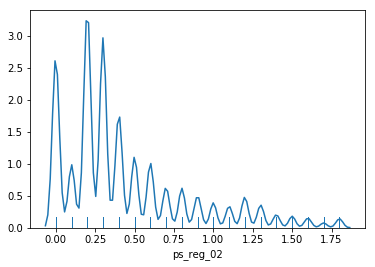

In [11]:
# Distribution of continuous features
import seaborn as sns
sns.distplot(X_train['ps_reg_02'], hist=False, rug=True)